In [1]:
# Data representation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as pxp
import plotly.graph_objs as gph
from yellowbrick.cluster import SilhouetteVisualizer
import graphviz

# Machine learning
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import scipy.cluster.hierarchy as ch
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import  KMeans, MeanShift, estimate_bandwidth, AgglomerativeClustering, DBSCAN
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Train and Testing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, silhouette_score, davies_bouldin_score

# Save and get model(s)
import pickle

# Data Preparation

### Data Collection / loading:

## Introduction

In this project, we will apply different stastistical methods, to try and analyse patterns and correlation in different lifestyle factors. This will involve trying to train different machine learning models, to see how precisely these patterns can be used to predict how much carbon is emitted based on the correlating factors.
We will try to answer the following questions: 

- Which machine learning methods did you choose to apply in the application?
- How accurate is your solution of prediction?
- Which are the most decisive factors for carbon emissions for an individual?
- Does internet usage directly affect total carbon emissions?
- Does people who see themselves as "energy efficient" generally have lower total carbon emissions?
- Does obesity affect the social acitivty in individuals?
- Are the people travelling frequently by plane, the ones who are emitting the most carbon?
- Which were the challenges in the project development?

In [2]:
# Reading the data from csv into pandas dataframe:
df = pd.read_csv('./data/Carbon-Emission.csv', index_col=None, na_values=['NA'])

In [3]:
# Viewing the size of the dataframe:
df.shape

(10000, 20)

In [4]:
df.sample(5)


,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
8098,overweight,male,vegan,more frequently,coal,public,NaN,often,177,never,168,extra large,4,15,38,4,Yes,[],"['Oven', 'Grill', 'Airfryer']",2337
2762,underweight,male,omnivore,more frequently,coal,walk/bicycle,NaN,often,278,frequently,82,large,5,3,39,12,No,"['Paper', 'Glass', 'Metal']","['Stove', 'Oven', 'Grill', 'Airfryer']",2791
6608,overweight,female,vegetarian,more frequently,electricity,public,NaN,sometimes,281,never,278,small,6,19,24,4,No,"['Paper', 'Glass', 'Metal']","['Stove', 'Oven', 'Microwave']",871
8100,obese,male,omnivore,more frequently,wood,walk/bicycle,NaN,never,217,never,3,small,1,6,25,6,Yes,"['Paper', 'Glass']","['Oven', 'Microwave']",1280
9307,obese,female,vegan,less frequently,wood,public,NaN,often,284,very frequently,1563,medium,1,6,24,24,No,"['Plastic', 'Glass', 'Metal']",['Oven'],2744


In [5]:
df.iloc[[7511]]

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
7511,obese,male,omnivore,daily,electricity,public,NaN,often,195,rarely,606,medium,2,7,15,24,Sometimes,"['Paper', 'Glass']","['Oven', 'Grill', 'Airfryer']",1574


In [6]:
list(df)

['Body Type',
 'Sex',
 'Diet',
 'How Often Shower',
 'Heating Energy Source',
 'Transport',
 'Vehicle Type',
 'Social Activity',
 'Monthly Grocery Bill',
 'Frequency of Traveling by Air',
 'Vehicle Monthly Distance Km',
 'Waste Bag Size',
 'Waste Bag Weekly Count',
 'How Long TV PC Daily Hour',
 'How Many New Clothes Monthly',
 'How Long Internet Daily Hour',
 'Energy efficiency',
 'Recycling',
 'Cooking_With',
 'CarbonEmission']

In [7]:
#
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Body Type                      10000 non-null  object
 1   Sex                            10000 non-null  object
 2   Diet                           10000 non-null  object
 3   How Often Shower               10000 non-null  object
 4   Heating Energy Source          10000 non-null  object
 5   Transport                      10000 non-null  object
 6   Vehicle Type                   3279 non-null   object
 7   Social Activity                10000 non-null  object
 8   Monthly Grocery Bill           10000 non-null  int64 
 9   Frequency of Traveling by Air  10000 non-null  object
 10  Vehicle Monthly Distance Km    10000 non-null  int64 
 11  Waste Bag Size                 10000 non-null  object
 12  Waste Bag Weekly Count         10000 non-null  int64 
 13  Ho

In [8]:
# Replacing nan values with None, this we do beacuse we know/can see that pepole that dont drive has nan values as vehicle type
df = df.replace(np.nan, 'None')

In [9]:
df.isnull().sum()

Body Type                        0
Sex                              0
Diet                             0
How Often Shower                 0
Heating Energy Source            0
Transport                        0
Vehicle Type                     0
Social Activity                  0
Monthly Grocery Bill             0
Frequency of Traveling by Air    0
Vehicle Monthly Distance Km      0
Waste Bag Size                   0
Waste Bag Weekly Count           0
How Long TV PC Daily Hour        0
How Many New Clothes Monthly     0
How Long Internet Daily Hour     0
Energy efficiency                0
Recycling                        0
Cooking_With                     0
CarbonEmission                   0
dtype: int64

In [10]:
# Getting some insights of the value scope:
df.describe()

,Monthly Grocery Bill,Vehicle Monthly Distance Km,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,CarbonEmission
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,173.875200,2031.485900,4.024600,12.139200,25.109000,11.889100,2269.147300
std,72.234018,2769.715597,1.990375,7.106369,14.698725,7.277218,1017.675247
min,50.000000,0.000000,1.000000,0.000000,0.000000,0.000000,306.000000
25%,111.000000,69.000000,2.000000,6.000000,13.000000,6.000000,1538.000000
50%,173.000000,823.000000,4.000000,12.000000,25.000000,12.000000,2080.000000
75%,237.000000,2516.750000,6.000000,18.000000,38.000000,18.000000,2768.000000
max,299.000000,9999.000000,7.000000,24.000000,50.000000,24.000000,8377.000000


In [11]:
# Chek numeric values for distribution
num_cols = df.select_dtypes(include=['int64']).columns
df_nums = df[num_cols]
df_nums.dtypes

Monthly Grocery Bill            int64
Vehicle Monthly Distance Km     int64
Waste Bag Weekly Count          int64
How Long TV PC Daily Hour       int64
How Many New Clothes Monthly    int64
How Long Internet Daily Hour    int64
CarbonEmission                  int64
dtype: object

array([[<Axes: title={'center': 'Monthly Grocery Bill'}>,
        <Axes: title={'center': 'Vehicle Monthly Distance Km'}>,
        <Axes: title={'center': 'Waste Bag Weekly Count'}>],
       [<Axes: title={'center': 'How Long TV PC Daily Hour'}>,
        <Axes: title={'center': 'How Many New Clothes Monthly'}>,
        <Axes: title={'center': 'How Long Internet Daily Hour'}>],
       [<Axes: title={'center': 'CarbonEmission'}>, <Axes: >, <Axes: >]],
      dtype=object)

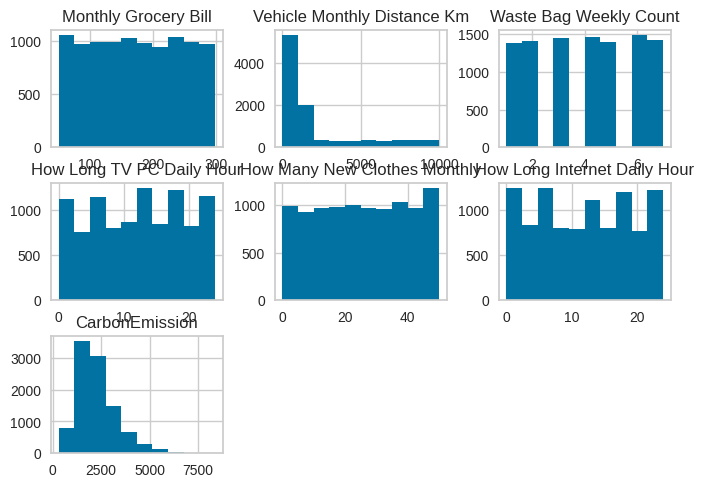

In [12]:
df_nums.hist()

In [13]:
# Encode/transform data numeric
label_encoder = LabelEncoder()

# Making copy of df to a new dataframe called: df_numeric 
df_numeric = df

# Gettning all columns that has object type:
cate_columns = df.select_dtypes(include=['object']).columns

for column in cate_columns:
    df_numeric[column] = label_encoder.fit_transform(df[column])

In [14]:
# Verifying that cols have been encoded:
df_numeric.sample(5)

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
2241,3,1,0,1,0,2,0,1,294,3,58,3,5,11,30,22,2,2,5,3053
9357,3,1,2,1,1,2,0,2,69,0,65,3,5,15,24,4,2,2,0,1363
9987,1,1,0,0,2,1,0,0,175,1,662,0,5,12,50,17,1,2,14,2644
928,0,0,3,0,2,0,2,0,239,2,3850,1,5,21,45,18,0,1,11,1961
851,3,1,0,0,2,0,1,2,101,3,189,1,2,14,50,12,2,1,15,2614


In [15]:
corr_matrix = df_numeric.corr()

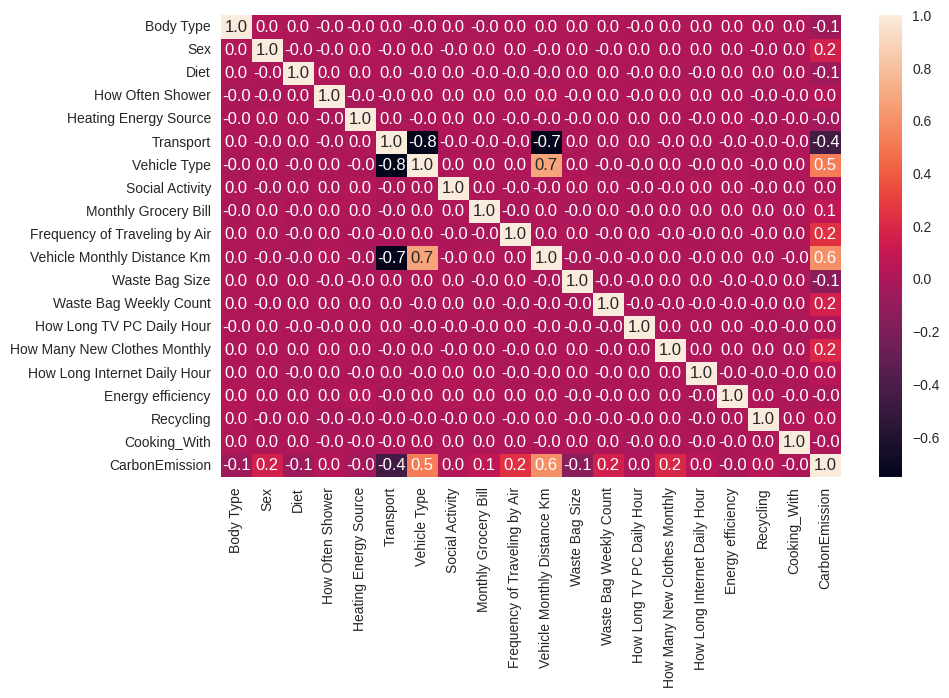

In [16]:
# Heatmap that can show correlation
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, fmt=".1f")
plt.show()

The biggest correlation with carbon emissions, seem to be the monthly travelled distance by vehicle. Other factor with clear correlations seem to be type of transport, vehicle type and frequency of travelling with airplane. There also seem to be a smaller correlation with the amount of clothes people buy.

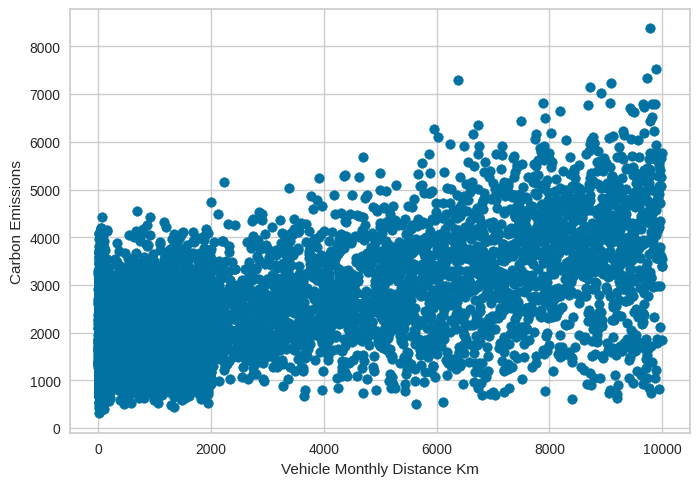

In [17]:
plt.xlabel('Vehicle Monthly Distance Km')
plt.ylabel('Carbon Emissions')
plt.scatter(df_numeric['Vehicle Monthly Distance Km'], df_numeric['CarbonEmission'])
plt.show()

Let's see if theres as difference between male an female patterns

In [18]:
# Split dataframe based on sex, and see if theres a difference in the correlation
df_male = df_numeric[df_numeric['Sex'] == 1]
df_male

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
2,2,1,0,2,3,0,5,0,138,1,2472,3,1,14,47,6,1,2,5,2595
3,2,1,0,3,3,2,0,2,157,2,74,2,3,20,5,7,1,6,1,1074
5,2,1,3,1,3,1,0,2,144,0,658,1,1,22,18,9,1,3,12,1647
8,2,1,0,0,3,1,0,0,200,0,1376,2,3,3,31,15,2,1,1,2494
11,1,1,3,2,0,2,0,0,111,3,69,2,5,9,4,4,1,15,12,3226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9992,1,1,0,2,0,1,0,0,120,2,421,1,3,10,33,6,2,9,7,2077
9993,3,1,1,2,3,2,0,2,118,0,78,2,3,8,14,10,1,15,6,1794
9995,1,1,0,3,0,0,3,2,230,1,268,2,5,12,27,9,2,15,2,2408
9998,3,1,2,2,0,0,5,1,179,2,8688,2,5,19,14,5,1,5,8,4574


In [19]:
df_female = df_numeric[df_numeric['Sex'] == 0]
df_female

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
0,2,0,1,0,0,1,0,1,230,0,210,1,4,7,26,1,0,2,13,2238
1,1,0,3,1,2,2,0,1,114,2,9,0,3,9,38,5,0,2,9,1892
4,1,0,3,0,0,0,1,1,266,3,8457,1,1,3,5,6,2,10,6,4743
6,3,0,2,1,3,0,3,0,56,2,5363,2,4,9,11,19,1,15,0,1832
7,3,0,2,2,0,2,0,2,59,3,54,0,3,5,39,15,0,7,9,2322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9990,3,0,0,2,1,1,0,2,226,0,755,2,7,16,17,4,2,8,9,1412
9991,1,0,0,2,0,2,0,0,55,2,82,2,2,19,10,11,1,0,2,1278
9994,0,0,3,2,3,0,5,0,89,2,4482,1,5,15,17,22,1,15,5,2999
9996,0,0,2,3,0,0,4,0,234,0,5316,0,3,14,8,24,1,9,9,3084


In [20]:
df_male_corr = df_male.corr()
df_female_corr = df_female.corr()

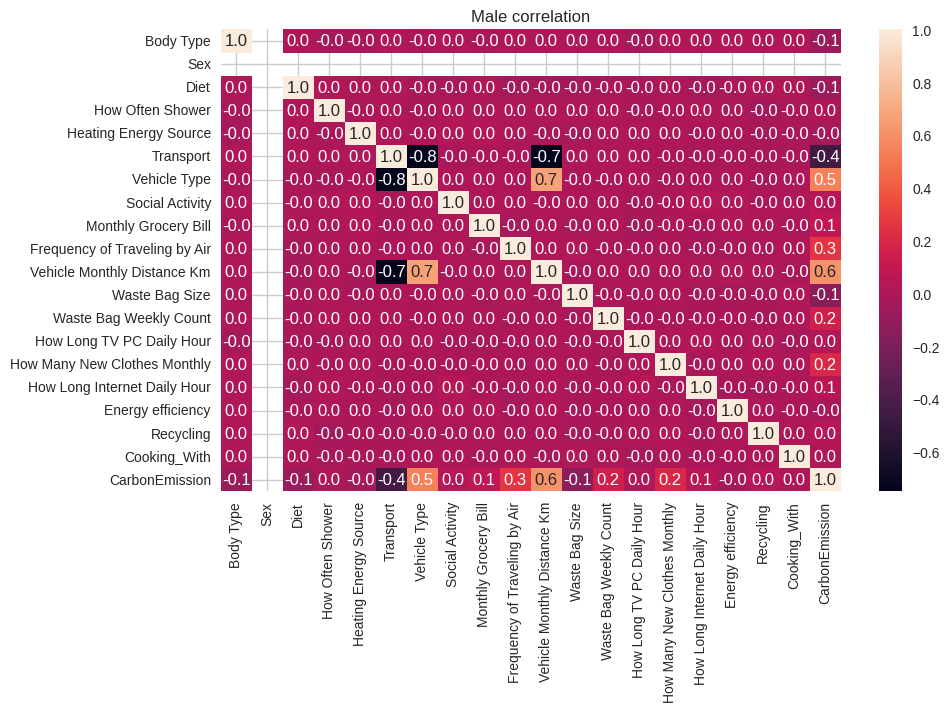

In [21]:
plt.figure(figsize=(10,6))
sns.heatmap(df_male_corr, annot=True, fmt=".1f")
plt.title('Male correlation')
plt.show()

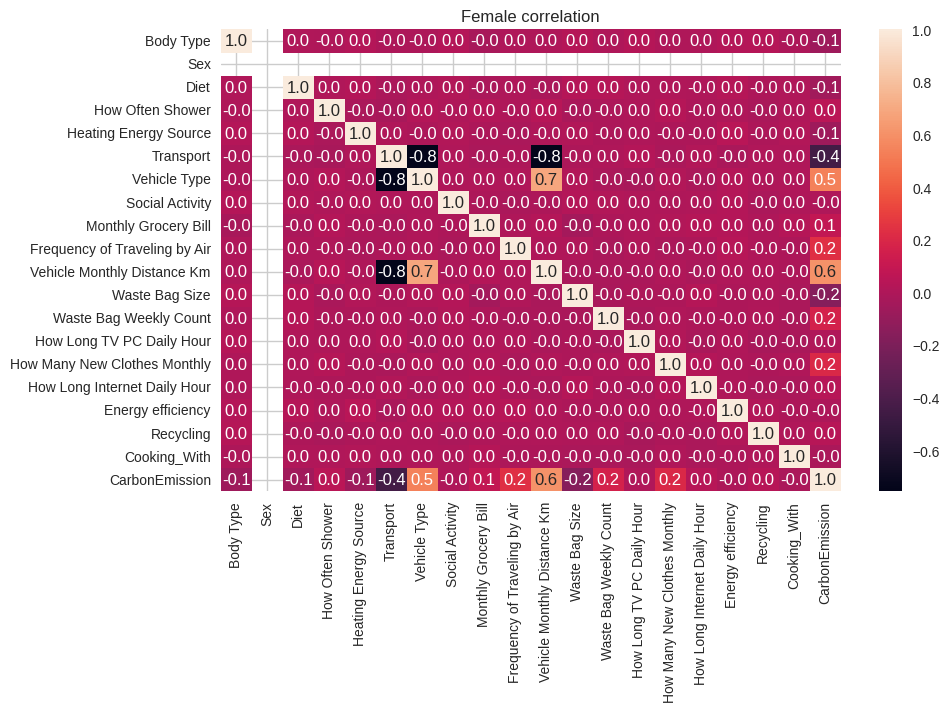

In [22]:
plt.figure(figsize=(10,6))
sns.heatmap(df_female_corr, annot=True, fmt=".1f")
plt.title('Female correlation')
plt.show()

There doesn't really seem to be a difference of how much the factors weigh between males and females

### Outliers

<Axes: >

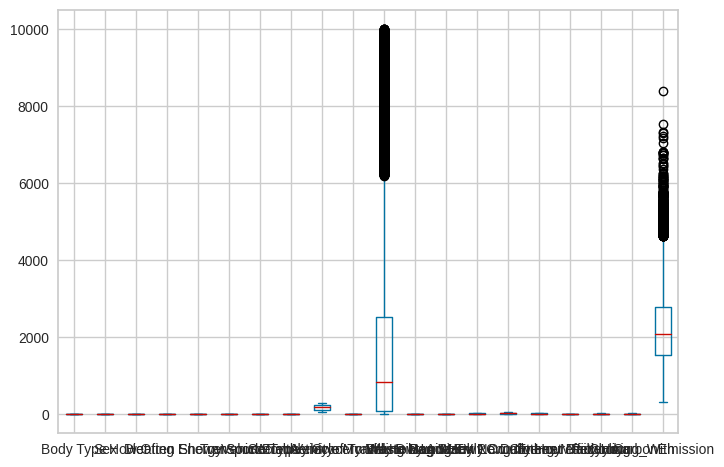

In [23]:
df_numeric.plot.box()

<Axes: >

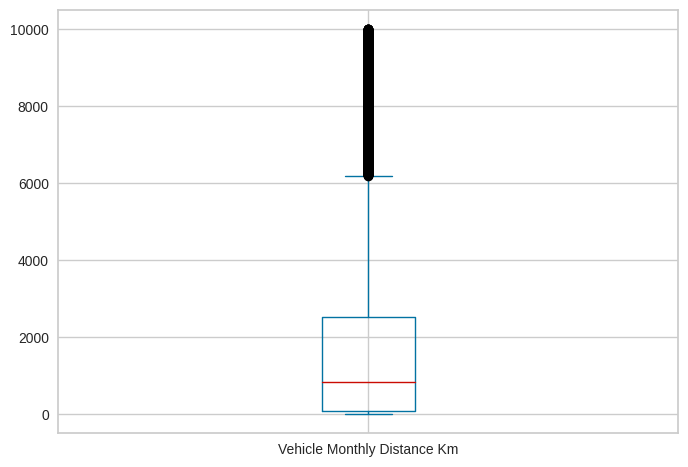

In [24]:
df_nums['Vehicle Monthly Distance Km'].plot.box()

In [25]:
med = df_nums['Vehicle Monthly Distance Km'].median()
df_nums['Vehicle Monthly Distance Km'].max() - med

9176.0

As we can see, the distribution of distance travelled by vehicle is very skewed, with 75% of the data lying beneath 3000 km pr month, with quite a few outlier being outragerously above the median. This might still be an accurate representation though, since some individuals just might travel that much. 
We'll keep it for the variance

Let's see if people are as accurate as they think, when they say they're energy efficient!

In [26]:
test = df_numeric.iloc[[6550]]
test

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
6550,3,1,2,3,3,2,0,2,157,3,13,3,2,20,45,12,2,3,2,2372


In [27]:
grouped_data = df.groupby('Energy efficiency')

grouped = df.groupby('Energy efficiency')['CarbonEmission'].agg(['mean', 'sum']).reset_index()
grouped

,Energy efficiency,mean,sum
0,0,2286.656628,7365321
1,1,2269.151314,7858071
2,2,2252.135404,7468081


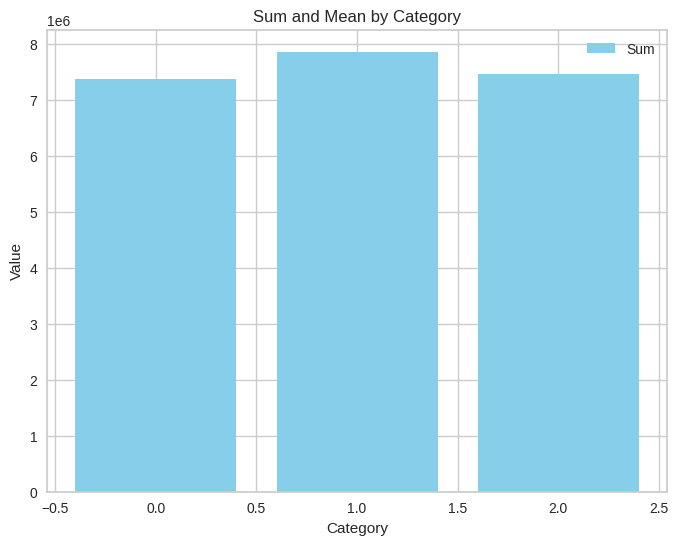

In [28]:
plt.figure(figsize=(8, 6))
plt.bar(grouped['Energy efficiency'], grouped['sum'], color='skyblue', label='Sum')
# plt.bar(grouped['Energy efficiency'], grouped['mean'], color='orange', label='Mean')
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('Sum and Mean by Category')
plt.legend()
plt.show()

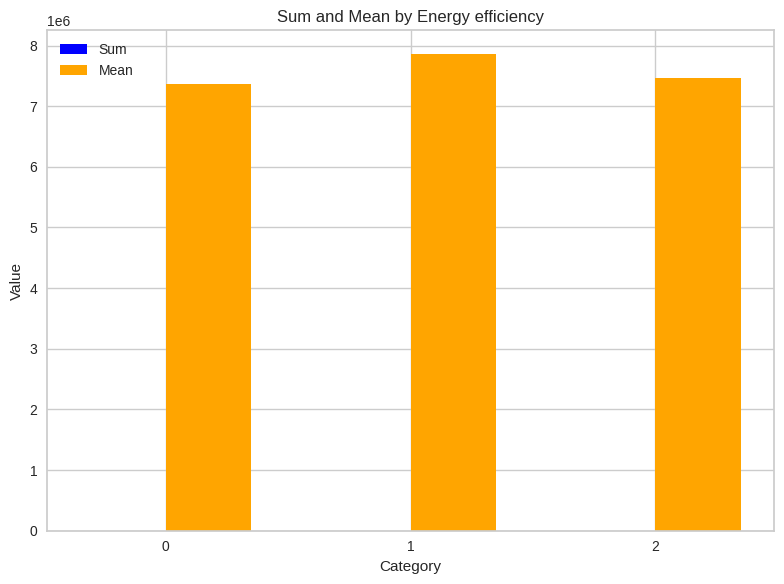

In [29]:
plt.figure(figsize=(8, 6))

# Define the width of each bar
bar_width = 0.35

# Define the positions for the bars
index = np.arange(len(grouped['Energy efficiency']))

# Create side-by-side bars for 'Sum' and 'Mean'
plt.bar(index, grouped['mean'], bar_width, color='blue', label='Sum')
plt.bar(index + bar_width, grouped['sum'], bar_width, color='orange', label='Mean')

# Add labels, title, and legend
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('Sum and Mean by Energy efficiency')
plt.xticks(index + bar_width / 2, grouped['Energy efficiency'])
plt.legend()

plt.tight_layout()
plt.show()

<Axes: xlabel='Energy efficiency'>

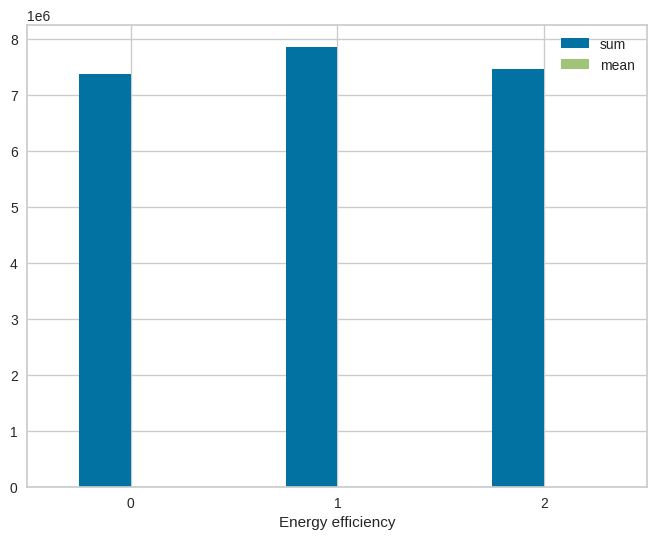

In [30]:
grouped['sum'] = grouped['sum'].astype(float)
grouped['mean'] = grouped['mean'].astype(float)
grouped.plot.bar(x='Energy efficiency', y=['sum','mean'], figsize=(8, 6), rot=0)

We can see that people say that the are energy efficient generally tend to have a little bit lower carbon emission in total, but the difference really is only about 1,5% lower than the 'No' category.

The total sum of carbon emissions seems to be higher by people declaring that they're being energy efficient, indicating that a lot more people think they are being efficient than not, while not really making any difference in the emitted carbon dioxide!

## Supervised Machine learning

Let's try and see if we can predict total carbon emission values by training different classifier models.
Since we're doing classification, we'll bin the carbon emission numbers into 5 categories

In [481]:
emission_max = df['CarbonEmission'].max()
emission_min = df['CarbonEmission'].min()

df_bin = df_numeric

bins = np.linspace(emission_min -1, emission_max, 6)

df_bin['EmissionBin'] = pd.cut(df_bin['CarbonEmission'], bins=5, labels=False)
df_bin.describe()


KeyError: 'CarbonEmission'

In [486]:
grouped_bin = df_bin.groupby('EmissionBin').size().reset_index(name='Count')
grouped_bin

,EmissionBin,Count
0,0,4321
1,1,4552
2,2,962
3,3,152
4,4,13


In [32]:
df_bin.drop('CarbonEmission', axis=1, inplace=True)
df_bin.sample(5)

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,EmissionBin
4179,1,0,0,0,3,1,0,0,68,3,973,3,3,24,15,21,2,2,8,1
9680,3,1,2,0,0,2,0,1,263,0,14,3,1,7,9,2,1,12,3,0
7100,1,0,2,1,1,0,3,1,89,0,5509,2,5,6,33,22,0,13,3,1
3292,3,1,3,3,1,1,0,0,266,1,843,2,7,2,14,5,1,5,0,0
6924,1,1,3,0,2,0,2,0,122,2,4277,0,7,8,49,3,2,12,8,1


#### Naive Bayes model

In [33]:
df_bin.head()

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,EmissionBin
0,2,0,1,0,0,1,0,1,230,0,210,1,4,7,26,1,0,2,13,1
1,1,0,3,1,2,2,0,1,114,2,9,0,3,9,38,5,0,2,9,0
2,2,1,0,2,3,0,5,0,138,1,2472,3,1,14,47,6,1,2,5,1
3,2,1,0,3,3,2,0,2,157,2,74,2,3,20,5,7,1,6,1,0
4,1,0,3,0,0,0,1,1,266,3,8457,1,1,3,5,6,2,10,6,2


In [34]:
# Convert the dataset into array
array = df_bin.values
# Create two axis for the test data
X = array[:,0:19] 
Y = array[:,-1]   # CarbonEmission
Y

array([1, 0, 1, ..., 1, 2, 0])

In [35]:
# split proportion
test_set_size = 0.15

# Initial value for randomization
seed = 42 # this is the answer
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=test_set_size, random_state=seed)

In [36]:
# Use GaussianNB for numeric data
nb = GaussianNB()
nb.fit(X_train, Y_train)

GaussianNB()

In [37]:
# test the model
nb.score(X_test, Y_test)

0.618

An accuracy of about 70 percent, not bad for a first try, but I think we can do better.
Let's try to focus on the correlating values

In [372]:
column_indexes = [0, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14]
df_features = df_numeric.iloc[:, column_indexes]
X = df_numeric.iloc[:, column_indexes].values
X


array([[ 2,  1,  0, ...,  1,  4, 26],
       [ 1,  3,  1, ...,  0,  3, 38],
       [ 2,  0,  2, ...,  3,  1, 47],
       ...,
       [ 2,  3,  0, ...,  0,  5,  5],
       [ 3,  2,  2, ...,  2,  5, 14],
       [ 1,  1,  3, ...,  3,  4,  6]])

In [39]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=test_set_size, random_state=seed)
Y_test.shape

(1500,)

In [40]:
nb = GaussianNB()
nb.fit(X_train, Y_train)

GaussianNB()

In [41]:
prediction = nb.predict(X_test)
prediction

array([0, 0, 1, ..., 1, 1, 1])

In [42]:
print(accuracy_score(Y_test, prediction))

0.7006666666666667


In [43]:
cmat = confusion_matrix(Y_test, prediction)
print(cmat)
print(classification_report(Y_test, prediction))

[[544  71  20   8   0]
 [155 443  67  36   0]
 [  0  37  36  50   0]
 [  0   1   2  28   0]
 [  0   0   0   2   0]]
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       643
           1       0.80      0.63      0.71       701
           2       0.29      0.29      0.29       123
           3       0.23      0.90      0.36        31
           4       0.00      0.00      0.00         2

    accuracy                           0.70      1500
   macro avg       0.42      0.53      0.43      1500
weighted avg       0.74      0.70      0.71      1500



/opt/anaconda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In the end, it made a bigger difference to adjust the test set size to around 15% of the set

### Decision Tree Classifier

In [429]:
test_set_size = 0.15
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=test_set_size, random_state=seed)
Y_test.shape

(1500,)

In [430]:
# Build Decision Trees Classifier 
params = {'max_depth': 6}
treeM = DecisionTreeClassifier(**params)
treeM.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=6)

In [431]:
gr_data = tree.export_graphviz(treeM, out_file=None, 
                         feature_names=df_features.columns, class_names = True,        
                         filled=True, rounded=True, proportion = False, special_characters=True)  
dtree = graphviz.Source(gr_data)

In [432]:
# render the tree as pdf
dtree.render('dtree_render', format='pdf', cleanup=True)

'dtree_render.pdf'

In [433]:
y_predict = treeM.predict(X_test)
y_predict

array([0, 1, 0, ..., 1, 1, 2])

In [434]:
cmat = confusion_matrix(Y_test, y_predict)
print(cmat)
print(classification_report(Y_test, y_predict))

[[515 118  10   0   0]
 [101 554  41   5   0]
 [  0  59  58   6   0]
 [  0   2  22   7   0]
 [  0   0   1   1   0]]
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       643
           1       0.76      0.79      0.77       701
           2       0.44      0.47      0.45       123
           3       0.37      0.23      0.28        31
           4       0.00      0.00      0.00         2

    accuracy                           0.76      1500
   macro avg       0.48      0.46      0.47      1500
weighted avg       0.76      0.76      0.75      1500



76% accuracy. Even better than before. Maybe our predictions can be even more accurate by using several decision trees

### Random Forest Classifier

In [469]:
test_set_size = 0.25
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=test_set_size, random_state=seed)
Y_test.shape

(2500,)

In [470]:
forest = RandomForestClassifier(n_estimators = 300, max_depth = 13)
forest.fit(X_train, Y_train)

RandomForestClassifier(max_depth=13, n_estimators=300)

#### Validation

In [471]:
y_predict = forest.predict(X_test)
y_predict

array([0, 0, 0, ..., 0, 1, 0])

In [472]:
cmat = confusion_matrix(Y_test, y_predict)
print(cmat)
print(classification_report(Y_test, y_predict))

[[920 131  20   0   0]
 [133 950  68   1   0]
 [  0 109 116   4   0]
 [  0   7  34   5   0]
 [  0   0   2   0   0]]
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      1071
           1       0.79      0.82      0.81      1152
           2       0.48      0.51      0.49       229
           3       0.50      0.11      0.18        46
           4       0.00      0.00      0.00         2

    accuracy                           0.80      2500
   macro avg       0.53      0.46      0.47      2500
weighted avg       0.79      0.80      0.79      2500



### Conclusion

At 80% accuracy the random fores classifier seems to be the most accurate model we have tested. It seems to correctly categorize a lot of the lower emitting categories, and is a little less accurate on cases with fewer instances. It's still making some big mistakes which might not show up in the overall calculated score, but is very significant.
For example, none of the models have succesfully caught any people in the topmost carbon emitting category. Perhaps implying, that the category data sould be binned differently, becuase if only very few instances fit into the bin, the model might not have any chance of recieving enough training data to be able to recognize the extreme cases.

## Unsupervised machine learning

### Applying the data to K-means, Hierarchical clustering, DBSCAN & Mean Shift

The perpose of applying these clustering models, is to see if, there are patterns in the data, that we haven't been able to see before.

In [ ]:
import warnings
warnings.filterwarnings('ignore')
scaler = StandardScaler()

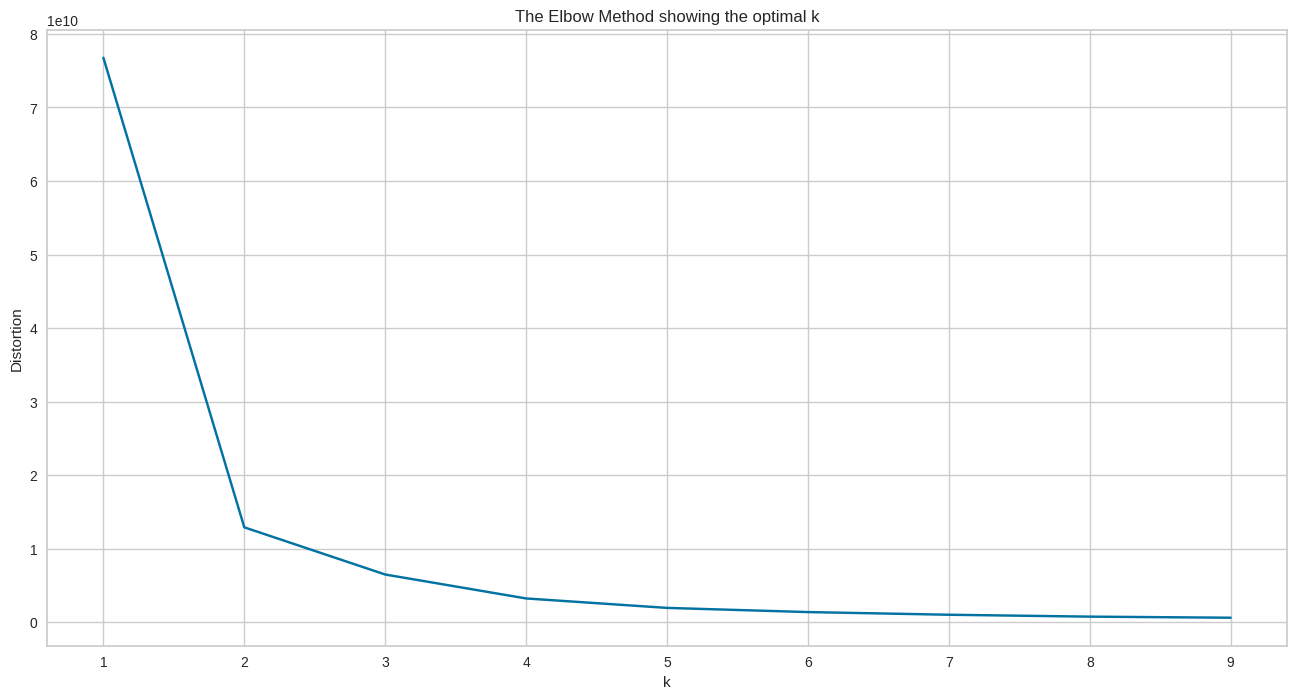

In [ ]:
X = df_numeric 
X = X.values

# Using the elbow method to find the optimal number of clusters
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
plt.figure(figsize=(20,10))

dendogram = ch.dendrogram(ch.linkage(X, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Euclidean distance')
plt.show()

KeyboardInterrupt: 

In [ ]:
n_clusters = 3
model = AgglomerativeClustering(n_clusters, affinity = 'euclidean', linkage = 'ward')
model.fit(X)

AgglomerativeClustering(affinity='euclidean', n_clusters=3)

In [ ]:
X

array([[   2,    0,    1, ...,    2,   13, 2238],
       [   1,    0,    3, ...,    2,    9, 1892],
       [   2,    1,    0, ...,    2,    5, 2595],
       ...,
       [   2,    0,    3, ...,    8,    1, 2377],
       [   3,    1,    2, ...,    5,    8, 4574],
       [   1,    1,    1, ...,   11,    3,  826]], dtype=int64)

In [ ]:
Y = model.fit_predict(X)
Y

array([2, 2, 1, ..., 2, 0, 0], dtype=int64)

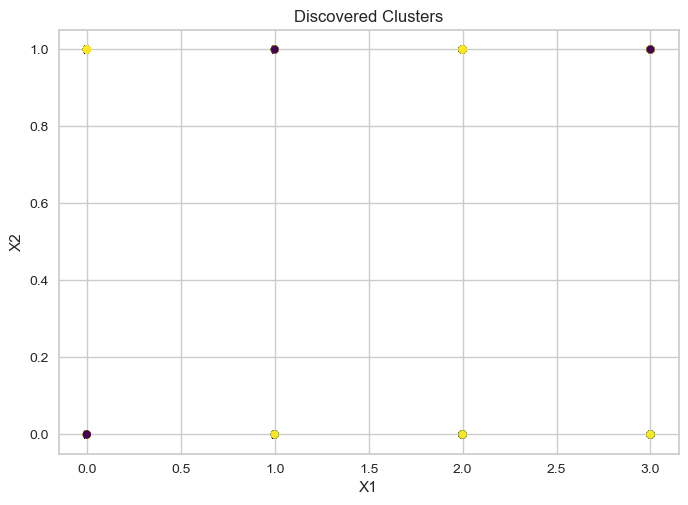

In [ ]:

plt.scatter(X[:, 0], X[:, 1], s=30, c=Y, cmap='viridis')
plt.title('Discovered Clusters')
plt.xlabel('X1')
plt.ylabel('X2')
# plt.legend()
plt.show()


### K-means

In [ ]:
X_kmeans = df_numeric 
X_kmeans = X_kmeans.values

X_kmeans

array([[   2,    0,    1, ...,    2,   13, 2238],
       [   1,    0,    3, ...,    2,    9, 1892],
       [   2,    1,    0, ...,    2,    5, 2595],
       ...,
       [   2,    0,    3, ...,    8,    1, 2377],
       [   3,    1,    2, ...,    5,    8, 4574],
       [   1,    1,    1, ...,   11,    3,  826]], dtype=int64)

In [ ]:

distortions = []
K = range(2,10)
for k in K:
    model = KMeans(n_clusters=k, n_init=10).fit(X_kmeans)
    model.fit(X_kmeans)
    distortions.append(sum(np.min(cdist(X_kmeans, model.cluster_centers_, 'euclidean'), axis=1)) / X_kmeans.shape[0]) 
print("Distortion: ", distortions)

Distortion:  [1213.0752925957836, 1021.5071234711668, 833.1622295595271, 726.9024688750078, 667.9283850925443, 634.5025753656996, 585.1943918712906, 561.1219225558754]


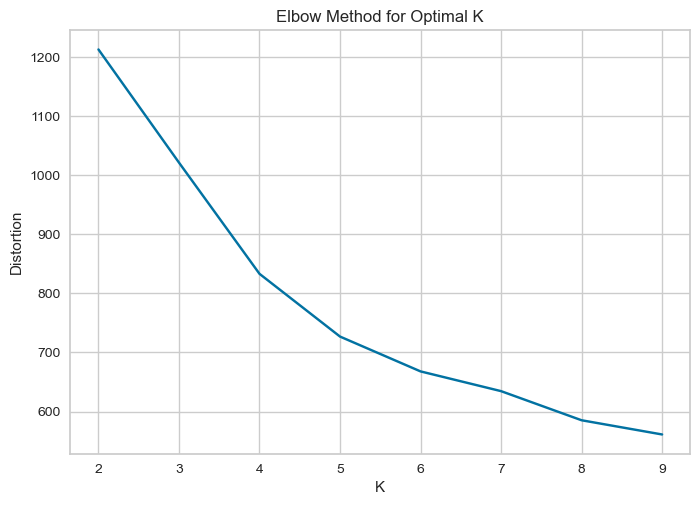

In [ ]:
plt.title('Elbow Method for Optimal K')
plt.plot(K, distortions, 'bx-')
plt.xlabel('K')
plt.ylabel('Distortion')
plt.show()

In [ ]:
k_clusters = 4

In [ ]:
kmeans = KMeans(init='k-means++', n_clusters=k_clusters, n_init=20)

In [ ]:
kmeans.fit(X_kmeans)

KMeans(n_clusters=4, n_init=20)

In [ ]:
scores = []
K = range(2, 10)
for k in K:
    model = KMeans(n_clusters=k, n_init=10)
    model.fit(X_kmeans)
    score = metrics.silhouette_score(X_kmeans, model.labels_, metric='euclidean', sample_size=len(X_kmeans))
    print("\nNumber of clusters =", k)
    print("Silhouette score =", score)
    scores.append(score)


Number of clusters = 2
Silhouette score = 0.7276288250547488

Number of clusters = 3
Silhouette score = 0.6244532103619639

Number of clusters = 4
Silhouette score = 0.4438990022372207

Number of clusters = 5
Silhouette score = 0.41728194444699995

Number of clusters = 6
Silhouette score = 0.41669291506780226

Number of clusters = 7
Silhouette score = 0.4157395408752782

Number of clusters = 8
Silhouette score = 0.4151932132932033

Number of clusters = 9
Silhouette score = 0.4153146080964341


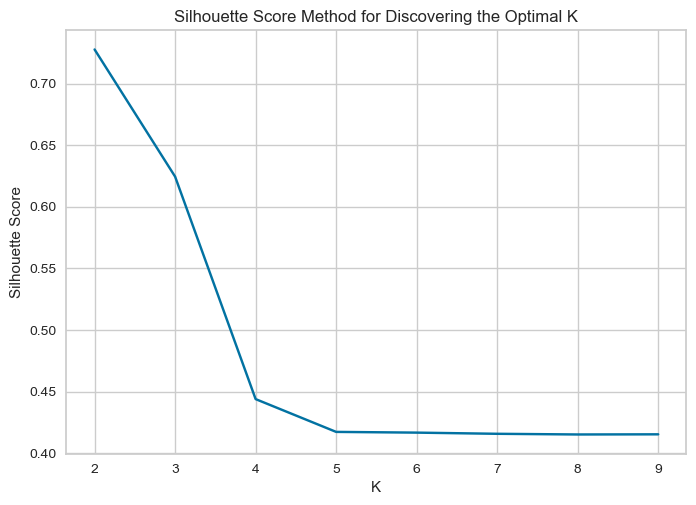

In [ ]:
# Plot the elbow
plt.title('Silhouette Score Method for Discovering the Optimal K')
plt.plot(K, scores, 'bx-')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.show()

In [ ]:
y = kmeans.predict(X_kmeans)
y

array([1, 1, 2, ..., 1, 3, 3])

In [ ]:
print(kmeans.labels_)

[1 1 2 ... 1 3 3]


Cluster  0 :  (1084, 20)


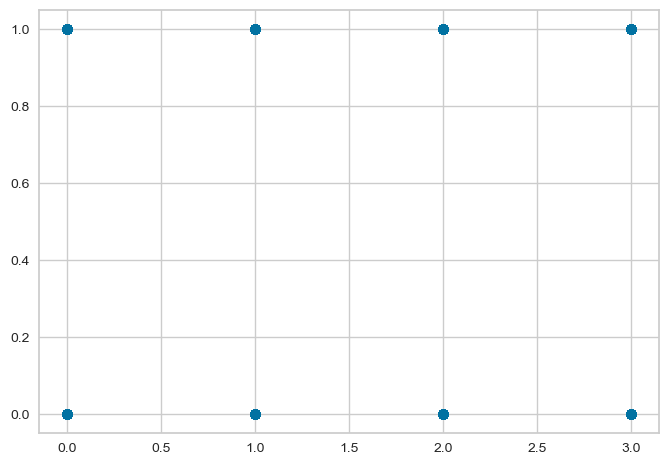

Cluster  1 :  (5250, 20)


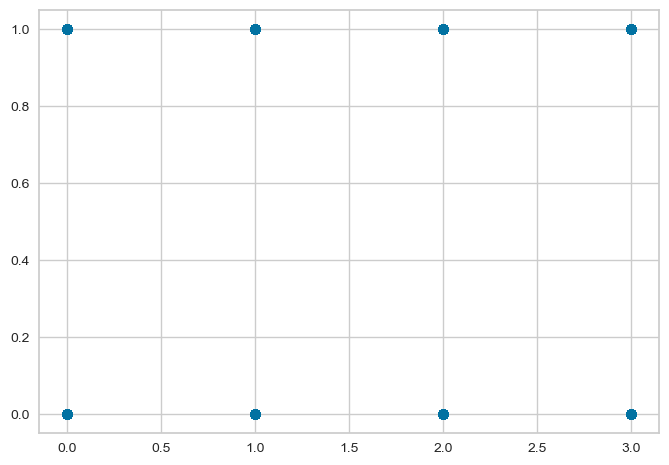

Cluster  2 :  (2550, 20)


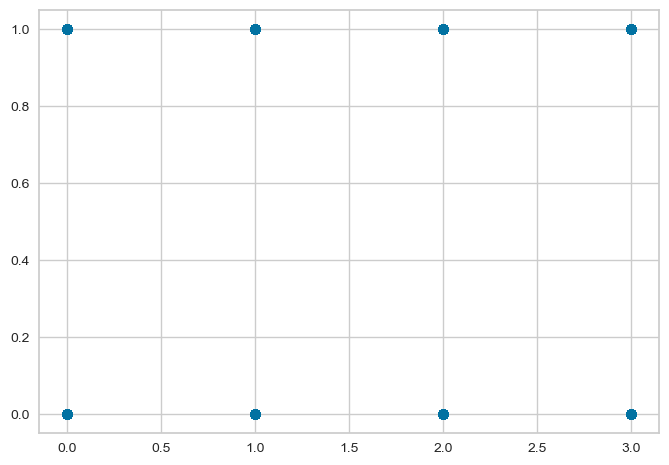

Cluster  3 :  (1116, 20)


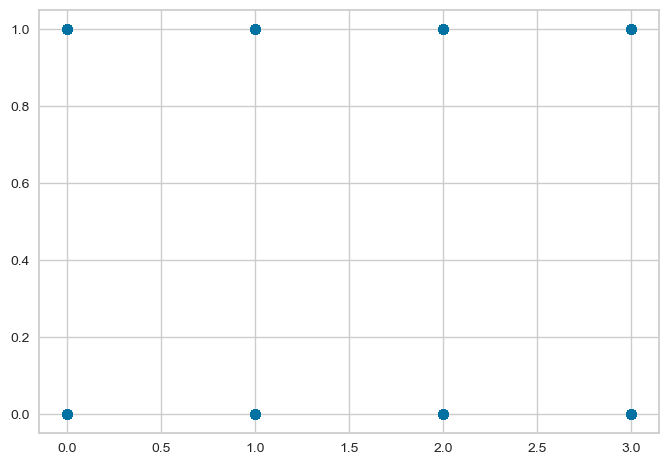

In [ ]:
for i in range(k_clusters):
    # slice the cluster
    cluster = X_kmeans[y == i]    
    # print the shape
    print("Cluster ", i, ": ", cluster.shape)    
    # plot the points of this cluster
    plt.scatter(cluster[:, 0], cluster[:, 1])   
    plt.grid(True)
    plt.show()

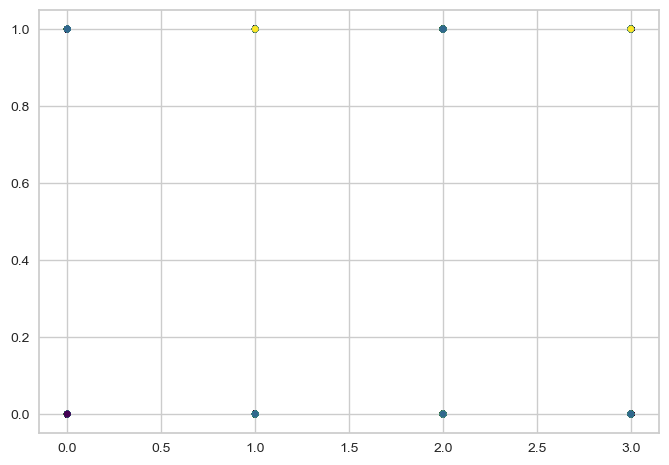

In [ ]:
plt.scatter(X_kmeans[:, 0], X_kmeans[:, 1], c=y, s=20, cmap='viridis')
plt.grid(True)
plt.show()

In [ ]:
print(kmeans.cluster_centers_)

[[1.54151292e+00 4.64944649e-01 1.44833948e+00 1.54520295e+00
  1.45664207e+00 5.55111512e-15 2.92343173e+00 9.98154982e-01
  1.71837638e+02 1.50369004e+00 5.10002030e+03 1.51476015e+00
  3.99907749e+00 1.17813653e+01 2.58007380e+01 1.21171587e+01
  1.05811808e+00 7.46402214e+00 7.46217712e+00 2.85269280e+03]
 [1.50685714e+00 4.97523810e-01 1.50628571e+00 1.47333333e+00
  1.49866667e+00 1.59847619e+00 1.65142857e-01 9.80380952e-01
  1.72186095e+02 1.48704762e+00 2.01140381e+02 1.51447619e+00
  4.01561905e+00 1.22400000e+01 2.48188571e+01 1.18295238e+01
  1.00552381e+00 7.53809524e+00 7.45504762e+00 1.88155867e+03]
 [1.50196078e+00 5.13725490e-01 1.50470588e+00 1.48705882e+00
  1.48196078e+00 6.88627451e-01 9.36470588e-01 1.00000000e+00
  1.75826275e+02 1.50901961e+00 1.70796549e+03 1.50666667e+00
  4.04509804e+00 1.19905882e+01 2.53113725e+01 1.19972549e+01
  9.97647059e-01 7.47529412e+00 7.69803922e+00 2.13639373e+03]
 [1.50716846e+00 5.08064516e-01 1.43727599e+00 1.55465950e+00
  1.4

In [ ]:
k = 5
model = KMeans(n_clusters=k, n_init=10)
model.fit_predict(X_kmeans)

array([4, 3, 0, ..., 4, 2, 2])

In [ ]:
score = silhouette_score(X_kmeans, model.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.417


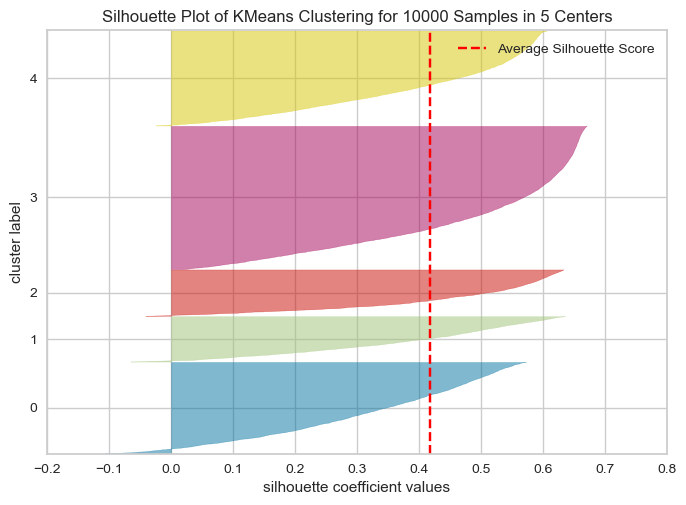

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 10000 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_kmeans)
visualizer.show()  

In [ ]:
x_ms = df_numeric
x_ms = x_ms.values

In [ ]:
bandwidth = estimate_bandwidth(x_ms, quantile=0.2, n_samples=200)
bandwidth 

1521.6254214114701

In [ ]:
msmodel = MeanShift(bandwidth=bandwidth, bin_seeding=True)
msmodel.fit(x_ms)

MeanShift(bandwidth=1521.6254214114701, bin_seeding=True)

In [ ]:
labels = msmodel.labels_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
n_clusters_

2

In [ ]:
cluster_centers = msmodel.cluster_centers_
cluster_centers
# Predict the cluster for all the samples
Y = msmodel.predict(x_ms)
Y

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

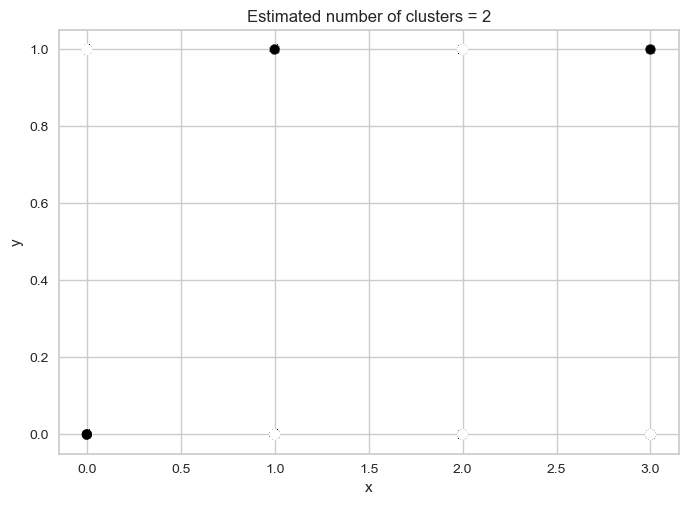

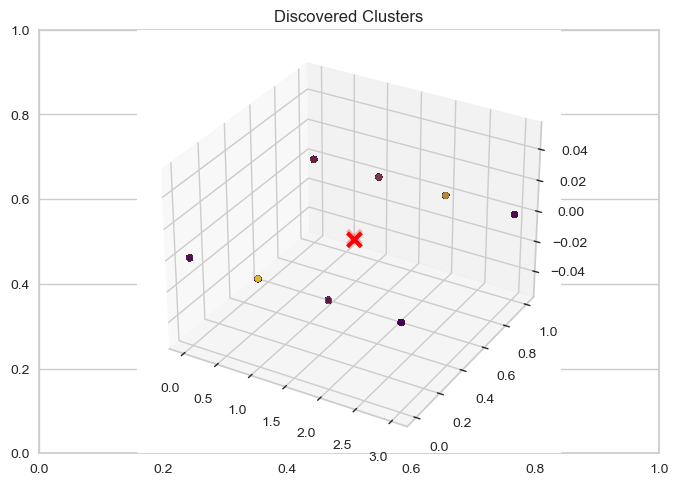

In [ ]:
len(msmodel.labels_)

# Generate scatter plot for the training data
# s - marker size, here, the dots size
# c - marker color, here taken from the predicted clusters
plt.scatter(x_ms[:,0], x_ms[:,1], c=labels, marker="o", picker=True)
plt.title(f'Estimated number of clusters = {n_clusters_}')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Visualising the clusters in 3D
fig = plt.figure()
plt.title('Discovered Clusters')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_ms[:,0], x_ms[:,1],  marker='o', cmap='viridis', c=labels)
ax.scatter(cluster_centers[:,0], cluster_centers[:,1], marker='x', 
           color='red', s=100, linewidth=3, zorder=10)
plt.show()

#### Multible cluster model testing

K-means Silhouette Score: 0.7272517673342564
K-means Davies-Bouldin Index: 0.47170236271604965


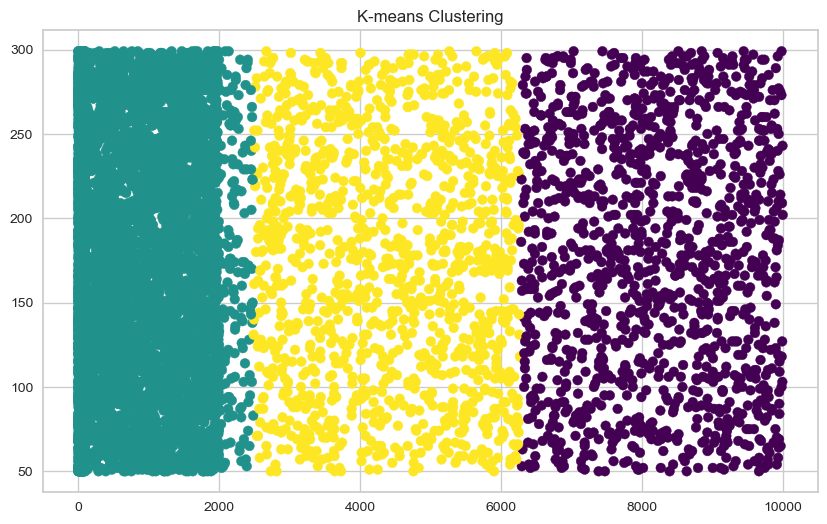


Hierarchical Silhouette Score: 0.6987582302409265
Hierarchical Davies-Bouldin Index: 0.48067426292775245


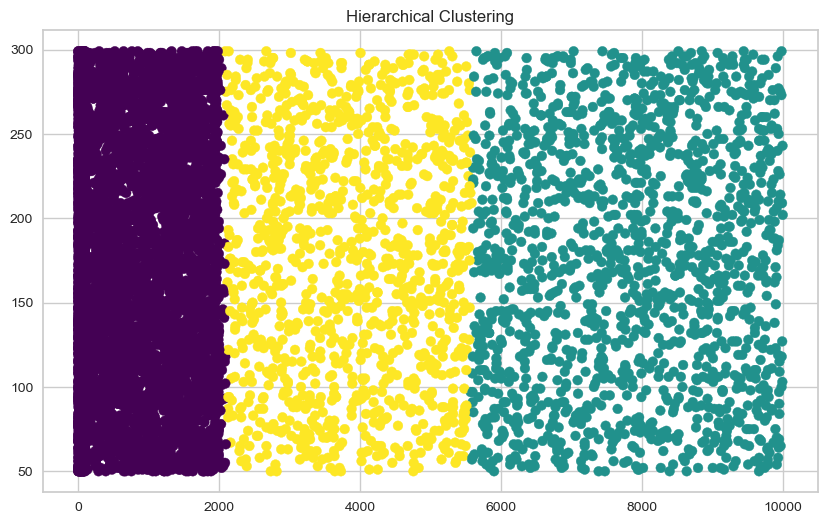


DBSCAN Silhouette Score:


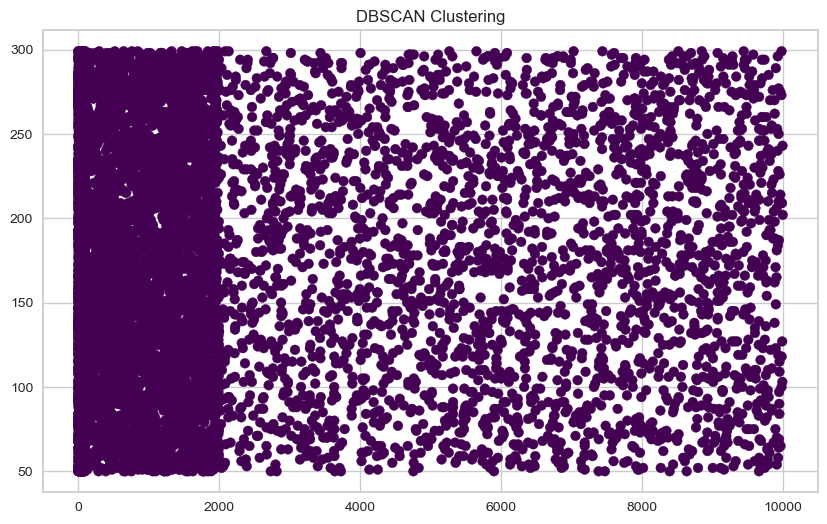


Mean Shift Silhouette Score: 0.5972466963485201
Mean Shift Davies-Bouldin Index: 0.5220474785135396


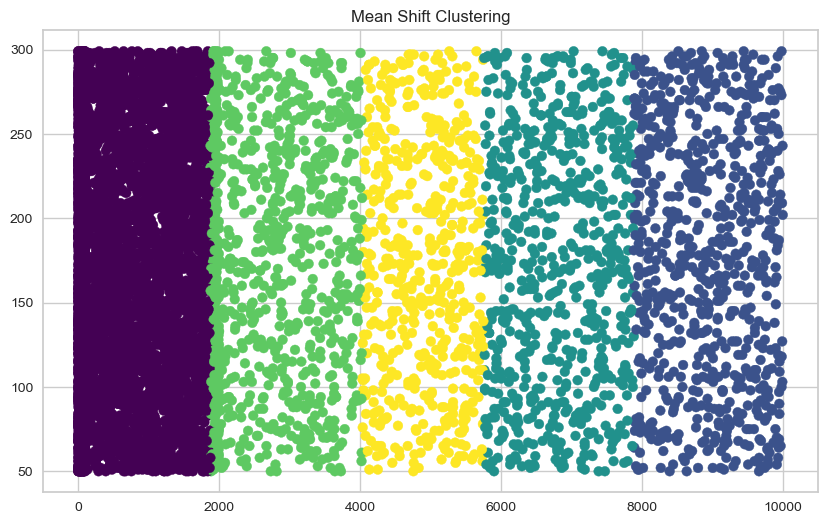

In [ ]:
data_scaled = df_numeric[['Vehicle Monthly Distance Km', 'Monthly Grocery Bill', 'Waste Bag Weekly Count', 'How Long TV PC Daily Hour', 'How Many New Clothes Monthly', 'How Long Internet Daily Hour']]
data_scaled = data_scaled.values


kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_clusters = kmeans.fit_predict(data_scaled)

hierarchical = AgglomerativeClustering(n_clusters=3)
hierarchical_clusters = hierarchical.fit_predict(data_scaled)

dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(data_scaled)

bandwidth = estimate_bandwidth(data_scaled, quantile=0.2, n_samples=500)
mean_shift = MeanShift(bandwidth=bandwidth)
mean_shift_clusters = mean_shift.fit_predict(data_scaled)


print("K-means Silhouette Score:", silhouette_score(data_scaled, kmeans_clusters))
print("K-means Davies-Bouldin Index:", davies_bouldin_score(data_scaled, kmeans_clusters))

plt.figure(figsize=(10, 6))
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=kmeans_clusters, cmap='viridis')
plt.title('K-means Clustering')
plt.show()

print()
print("Hierarchical Silhouette Score:", silhouette_score(data_scaled, hierarchical_clusters))
print("Hierarchical Davies-Bouldin Index:", davies_bouldin_score(data_scaled, hierarchical_clusters))

plt.figure(figsize=(10, 6))
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=hierarchical_clusters, cmap='viridis')
plt.title('Hierarchical Clustering')
plt.show()


print()

print("DBSCAN Silhouette Score:")

plt.figure(figsize=(10, 6))
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=dbscan_clusters, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.show()

print()

print("Mean Shift Silhouette Score:", silhouette_score(data_scaled, mean_shift_clusters))
print("Mean Shift Davies-Bouldin Index:", davies_bouldin_score(data_scaled, mean_shift_clusters))

plt.figure(figsize=(10, 6))
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=mean_shift_clusters, cmap='viridis')
plt.title('Mean Shift Clustering')
plt.show()


#### Clustering conclusion:

We have try using K-means, Hierarchical clustering, DBSCAN & Mean shift to see if there are any patterns in the data, but it seems that there are no clear patterns in the data, when applying these clustering methods to the hole dataset. We have tried with and without scaling the data. Additionally, we have tried to use different numbers of clusters, but the results are still the same. 
This is concluded based on the visualisation of the clusters from the different methods due to the visualistations being porly; However, the silhouette score have actually been quite high, which indicates that there are some patterns in the data.

Silhouette score:
* K-means: 0.727 (with 2 clusters), 0.624 (with 3 clusters)
* Hierarchical clustering: 0.426
* Mean shift: 0.727
* DBSCAN: indicates one clusters in the data

We have also tried using only some parts of the datas features, these results are gives som visualisation endication of patterns.
The features used for the clustering are: 'Monthly Grocery Bill', 'Waste Bag Weekly Count', 'How Long TV PC Daily Hour', 'How Many New Clothes Monthly', 'How Long Internet Daily Hour'

Silhouette score:
* K-means: 0.79 (with 2 clusters), 0.727 (with 3 clusters)
* Hierarchical clustering: 0.698
* Mean shift: 0.597
* DBSCAN: indicates one clusters in the data

Other features combinations have also been tried, but the results gives similar visualisation and silhouette score.